In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from ImplicitDenoising import *
from EnKF import *

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def Lorenz(X,params = (10,28,8/3)):
    """
    Time derivative of Lorenz equation
    """
    
    sigma,rho,beta = params
    m = tf.shape(X).eval()[1]
    
    x = tf.slice(X, [0,0], [1,m])
    y = tf.slice(X, [1,0], [1,m])
    z = tf.slice(X, [2,0], [1,m])
    
    X_t = tf.concat([sigma*(y-x), \
                   x*(rho-z)-y, \
                   x*y-beta*z],axis=0)
    
    return X_t

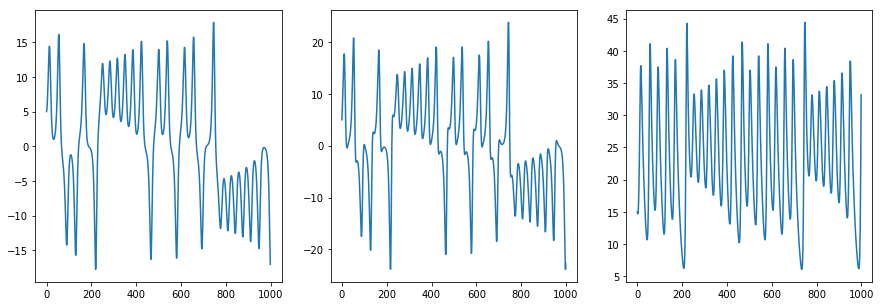

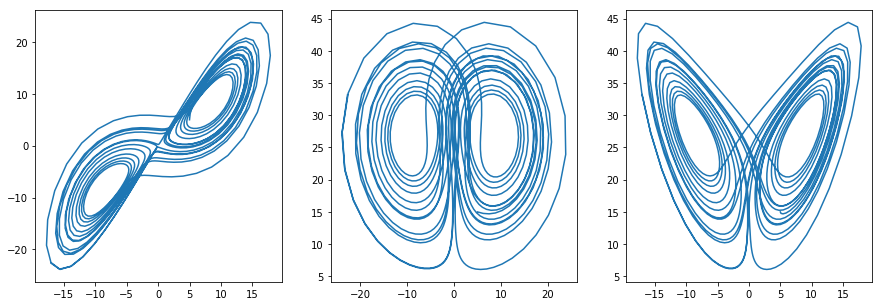

In [3]:
def lorenz_ode(X, t, params):
    s,r,b = params
    x,y,z = X
    return [s*(y-x), x*(r-z)-y, x*y-b*z]

M = 10000
subsample_rate = 10

subsample = [j for j in range(M) if j%subsample_rate == 0]
m = len(subsample); n = 3

t = np.linspace(0,20,M); dt = (t[1]-t[0])*subsample_rate


params = (10,28,8.0/3)
X = odeint(lorenz_ode, [5,5,15], t, args=(params,), rtol = 1e-12, atol = 1e-12)[subsample, :].T
x = X[0,:]; y = X[1,:]; z = X[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(x)
subplot(1,3,2); plot(y)
subplot(1,3,3); plot(z)
figure()
subplot(1,3,1); plot(x, y)
subplot(1,3,2); plot(y, z)
subplot(1,3,3); plot(x, z)

In [4]:
def RK4(x, f, params, h):
    
    b = [1/6,1/3,1/3,1/6]
    A = [[],[1/2],[0, 1/2],[0,0,1]]

    k1 = np.array(f(x, 0, params))
    k2 = np.array(f(x + h*A[1][0]*k1, 0, params))
    k3 = np.array(f(x + h*A[2][0]*k1 + h*A[2][1]*k2, 0, params))
    k4 = np.array(f(x + h*A[3][0]*k1 + h*A[3][1]*k2 + h*A[3][2]*k3, 0, params))
    
    return x+h*(b[0]*k1+b[1]*k2+b[2]*k3+b[3]*k4)

def Lorenz_step(x, h = dt, params = (10,28,8.0/3)):
    
    return RK4(x, lorenz_ode, params, h)

In [5]:
n_trials = 25
noise_percent = 100
n_ensemble = 500

RMSE = {'white' : [], \
        'red' : [], \
        'DC_1' : [], \
        'DC_5' : [], \
        'DC_10' : [], \
        'student' : []}
RMSE_unknown = {'white' : [], \
        'red' : [], \
        'DC_1' : [], \
        'DC_5' : [], \
        'DC_10' : [], \
        'student' : []}
RMSE_kalman = {'white' : [], \
        'red' : [], \
        'DC_1' : [], \
        'DC_5' : [], \
        'DC_10' : [], \
        'student' : []}

noise_level = [0.01*noise_percent*np.var(X[j,:]) for j in range(n)]
Q = (dt**4)**2*np.eye(n)
R = np.diag(noise_level)
deg_free = 10

for j in range(n_trials):
    
    print('\nTrial', j, '\n')
    
    # White noise
    measurement_noise_gaussian = np.vstack([np.sqrt(noise_level[j])*np.random.randn(m) for j in range(n)])

    # OR noise
    r = 0.75
    measurement_noise_OR = np.zeros_like(measurement_noise_gaussian)
    measurement_noise_OR[:,0] = measurement_noise_gaussian[:,0]
    for j in range(1,m): measurement_noise_OR[:,j] = r*measurement_noise_OR[:,j-1] + \
                                                  (1-r**2)**0.5*measurement_noise_gaussian[:,j]
            
    
    measurement_noise_sdt = np.random.standard_t(deg_free, size=(3,m))
    measurement_noise_sdt = np.vstack([np.sqrt(noise_level[j])*measurement_noise_sdt[j,:]/ \
                                       np.std(measurement_noise_sdt[j,:]) for j in range(n)])
    
    # DC offset
    DC_shift = np.random.randn(3,1)
    DC_shift = DC_shift / np.linalg.norm(DC_shift)
    
    measurement_noise_1 = measurement_noise_gaussian + DC_shift
    measurement_noise_5 = measurement_noise_gaussian + 5*DC_shift
    measurement_noise_10 = measurement_noise_gaussian + 10*DC_shift
    
    measurement_noises = {'white' : measurement_noise_gaussian, \
        'red' : measurement_noise_OR, \
        'DC_1' : measurement_noise_1, \
        'DC_5' : measurement_noise_5, \
        'DC_10' : measurement_noise_10, \
        'student' : measurement_noise_sdt}
    
    for key, measurement_noise in measurement_noises.items():
        
        Y = X + measurement_noise
        if key in ['white', 'red']: noise_penalty = 'L2'
        else: noise_penalty = 'L1'
        
        #
        # Denoise with standard method
        #
        tf.reset_default_graph()
        sess = tf.InteractiveSession()
        optimizer, X_hat_tf, cost = create_computational_graph(Y, t[subsample], Lorenz, method = 'Gauss3', noise_penalty = noise_penalty)
        init = tf.global_variables_initializer()
        sess.run(init)
        optimizer.minimize(sess)
        RMSE[key].append(np.sqrt(np.mean(X_hat_tf.eval() - X)**2))
        sess.close()
        
        #
        # Denoise with unknown parameters mu, sigma, rho
        #
        tf.reset_default_graph()
        sess = tf.InteractiveSession()

        sigma_hat = tf.get_variable(shape = [1], dtype = tf.float32, name = 'sigma_hat')
        rho_hat = tf.get_variable(shape = [1], dtype = tf.float32, name = 'rho_hat')
        beta_hat  = tf.get_variable(shape = [1], dtype = tf.float32, name = 'beta_hat')

        def Lorenz_unknown_params(X, params = (sigma_hat,rho_hat,beta_hat)):
            return Lorenz(X,params)

        optimizer, X_hat_tf, cost = create_computational_graph(Y, t[subsample], Lorenz_unknown_params, method = 'Gauss3')
        init = tf.global_variables_initializer()
        sess.run(init)
        optimizer.minimize(sess)
        RMSE_unknown[key].append(np.sqrt(np.mean(X_hat_tf.eval() - X)**2))
        sess.close()
        
        #
        # Denoise with Ensemble RTS Smoother
        #
        Ef, Ea, Es = EnRTS(Y, Lorenz_step, lambda x: x, Y[:,0], R, R, Q, n_ensemble)
        RMSE_kalman[key].append(np.sqrt(np.mean(Es.mean(1) - X)**2))



Trial 0 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.001069
  Number of iterations: 5967
  Number of functions evaluations: 6013
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.001168
  Number of iterations: 17201
  Number of functions evaluations: 19419
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.001163
  Number of iterations: 8927
  Number of functions evaluations: 8998
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.001381
  Number of iterations: 21976
  Number of functions evaluations: 24930
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function 

In [9]:
save_path = "./saved_data/"

# Save results to JSON files
if True:
    np.save(save_path+"L63_boxplots.npy", [RMSE, RMSE_unknown, RMSE_kalman])
    
# Load results from JSON files
if False:
    RMSE, RMSE_unknown, RMSE_kalman = np.load(save_path+"L63_boxplots.npy")


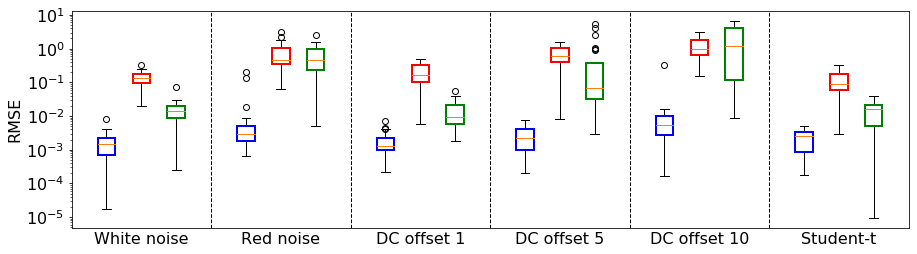

In [10]:
figure(figsize = (15,4))

lw = 2
label_fs = 16


bp1 = boxplot([RMSE[key] for key in RMSE.keys()], positions = np.arange(6)*4, patch_artist=True)
for box, whisker,cap in zip(bp1['boxes'], bp1['whiskers'], bp1['caps']):
    box.set(color='blue', linewidth=lw)
    box.set(facecolor = 'w' )
#     whisker.set(color='blue', linewidth=lw)
#     cap.set(color='blue', linewidth=lw)

bp2 = boxplot([RMSE_unknown[key] for key in RMSE.keys()], positions = np.arange(6)*4+1, patch_artist=True)
for box, whisker, cap in zip(bp2['boxes'], bp2['whiskers'], bp2['caps']):
    box.set(color='red', linewidth=lw)
    box.set(facecolor = 'w' )
#     whisker.set(color='red', linewidth=lw)
#     cap.set(color='red', linewidth=lw)

bp3 = boxplot([RMSE_kalman[key] for key in RMSE.keys()], positions = np.arange(6)*4+2, patch_artist=True)
for box, whisker, cap, median in zip(bp3['boxes'], bp3['whiskers'], bp3['caps'], bp3['medians']):
    box.set(color='green', linewidth=lw)
    box.set(facecolor = 'w' )
#     whisker.set(color='green', linewidth=lw)
#     cap.set(color='green', linewidth=lw)
#     median.set(linewidth=lw)

yscale('log')
axvline(x=3, color = 'k', linestyle = '--', linewidth = 1)
axvline(x=7, color = 'k', linestyle = '--', linewidth = 1)
axvline(x=11, color = 'k', linestyle = '--', linewidth = 1)
axvline(x=15, color = 'k', linestyle = '--', linewidth = 1)
axvline(x=19, color = 'k', linestyle = '--', linewidth = 1)

xlim([-1,23])
xticks([1,5,9,13,17, 21], ['White noise', 'Red noise', 'DC offset 1', 'DC offset 5', 'DC offset 10', 'Student-t'], \
       fontsize = label_fs)
tick_params(axis='x', length = 0)

yticks(fontsize = 16)
ylabel('RMSE', fontsize = 16)